In [1]:
from __future__ import division
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import imageio

from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Conv2DTranspose, Activation, Reshape, LayerNormalization, BatchNormalization
from tensorflow.keras.layers import Input, Dropout, Concatenate, Dense, LeakyReLU, Flatten
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model

AUTOTUNE = tf.data.experimental.AUTOTUNE

## Training parameters

Setup trainnig parameters

In [2]:
date = "12_8_1"
MODEL_NAME = 'DCGAN'
DATA_BASE_DIR = 'dataset/images/'
OUTPUT_PATH = os.path.join('outputs', MODEL_NAME)
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", date+"_"+MODEL_NAME, 'train_data') # Sets up a log directory.
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
TARGET_IMG_SIZE = 64 

BATCH_SIZE = 64
NOISE_DIM = 100
LAMBDA = 10

EPOCHs = 30
CURRENT_EPOCH = 1 
SAVE_EVERY_N_EPOCH = 15 

N_CRITIC = 3
LR = 1e-4
MIN_LR = 0.000001
DECAY_FACTOR=1.00004

file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)

In [3]:
list_ds = tf.data.Dataset.list_files('../../DL_data/13-2/datalab-lab-14-2/img_align_celeba_png/img_align_celeba_png/*')

for f in list_ds.take(5):
    print(f.numpy())

b'..\\..\\DL_data\\13-2\\datalab-lab-14-2\\img_align_celeba_png\\img_align_celeba_png\\111330.png'
b'..\\..\\DL_data\\13-2\\datalab-lab-14-2\\img_align_celeba_png\\img_align_celeba_png\\072114.png'
b'..\\..\\DL_data\\13-2\\datalab-lab-14-2\\img_align_celeba_png\\img_align_celeba_png\\187906.png'
b'..\\..\\DL_data\\13-2\\datalab-lab-14-2\\img_align_celeba_png\\img_align_celeba_png\\062579.png'
b'..\\..\\DL_data\\13-2\\datalab-lab-14-2\\img_align_celeba_png\\img_align_celeba_png\\020962.png'


## Preprocess
normalize and resize images to 64 x 64 for training.

In [4]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image

def preprocess_image(file_path):
    images = tf.io.read_file(file_path)

    images = tf.image.decode_jpeg(images, channels=3)
    images = tf.image.resize(images, (TARGET_IMG_SIZE, TARGET_IMG_SIZE),
                           method='bicubic', antialias=True)
    images = normalize(images)
    return images

In [5]:
train_data = list_ds.map(preprocess_image).shuffle(1000).batch(BATCH_SIZE)
# train_data = list_ds.map(preprocess_image).batch(BATCH_SIZE)

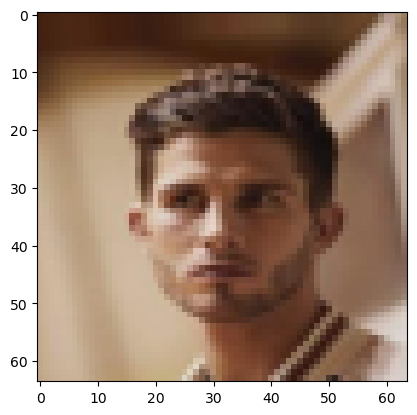

In [6]:
sample_img = next(iter(train_data))
plt.imshow(np.clip(sample_img[0] * 0.5 + 0.5, 0, 1))

## Build genertor and discriminator

In [7]:
def CGAN_generator(input_z_shape=NOISE_DIM):
    input_z_layer = Input(input_z_shape)
    
    z = Dense(4*4*512, use_bias=False)(input_z_layer)
    z =Reshape((4, 4, 512))(z)
    
    x = Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(z)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    output = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation="tanh",
                             kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    model = Model(inputs=input_z_layer, outputs=output)
    return model

def CGAN_discriminator(input_x_shape=(TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)):

    input_x_layer = Input(input_x_shape)
    
    x = Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input_x_layer)
    x = LeakyReLU()(x)
    
    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    x = Flatten()(x)
    
    output = Dense(1)(x)
    
    model = Model(inputs=input_x_layer, outputs=output)
    return model

In [9]:
generator = CGAN_generator()
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 8192)              819200    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         4194304   
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 512)         2048      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         209715

In [11]:
discriminator = CGAN_discriminator()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        3072      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131072    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         524288    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 256)         0   

optimizer

Functions to set learning rate

In [12]:
D_optimizer = Adam(learning_rate=LR, beta_1=0.5)
G_optimizer = Adam(learning_rate=LR, beta_1=0.5)

def learning_rate_decay(current_lr, decay_factor=DECAY_FACTOR):
    new_lr = max(current_lr / decay_factor, MIN_LR)
    return new_lr

def set_learning_rate(new_lr):
    K.set_value(D_optimizer.lr, new_lr)
    K.set_value(G_optimizer.lr, new_lr)

To save the model parameters, setup checkpoints

In [13]:
checkpoint_path = os.path.join("checkpoints", "tensorflow", MODEL_NAME)

ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           G_optimizer=G_optimizer,
                           D_optimizer=D_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[1])
    CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))



In [15]:
num_examples_to_generate = 16*16
sample_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])

## training step

In [16]:
@tf.function
def WGAN_GP_train_d_step(real_image, batch_size, step):

    noise = tf.random.normal([batch_size, NOISE_DIM])
    epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)

    # Train D
    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:
            fake_image = generator([noise], training=True)
            fake_image_mixed = epsilon * tf.dtypes.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)
            fake_mixed_pred = discriminator([fake_image_mixed], training=True)
            

        grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))
        
        fake_pred = discriminator([fake_image], training=True)
        real_pred = discriminator([real_image], training=True)
        
        D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty

    D_gradients = d_tape.gradient(D_loss, discriminator.trainable_variables)
    D_optimizer.apply_gradients(zip(D_gradients, discriminator.trainable_variables))
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('D_loss', tf.reduce_mean(D_loss), step=step)
    return D_loss

@tf.function
def WGAN_GP_train_g_step(real_image, batch_size, step):

    noise = tf.random.normal([batch_size, NOISE_DIM])

    # Train G
    with tf.GradientTape() as g_tape:
        fake_image = generator([noise], training=True)
        fake_pred = discriminator([fake_image], training=True)
        G_loss = -tf.reduce_mean(fake_pred)

    G_gradients = g_tape.gradient(G_loss, generator.trainable_variables)
    G_optimizer.apply_gradients(zip(G_gradients, generator.trainable_variables))
    
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('G_loss', G_loss, step=step)
    return G_loss

In [17]:
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

## Starting training

In [18]:
current_learning_rate = LR
trace = True
n_critic_count = 0
wsp = [None] * (EPOCHs)
wlg = [None] * (EPOCHs)
wld = [None] * (EPOCHs)
count = 0
for epoch in range(0, EPOCHs):
    count+=1
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    # Using learning rate decay
    current_learning_rate = learning_rate_decay(current_learning_rate)
    print('current_learning_rate %f' % (current_learning_rate,))
    set_learning_rate(current_learning_rate)
    total_G_loss = 0
    total_D_loss = 0
    for step, (image) in enumerate(train_data):
        current_batch_size = image.shape[0]

        total_D_loss+=WGAN_GP_train_d_step(image, batch_size=tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
        n_critic_count += 1
        if n_critic_count >= N_CRITIC: 
            total_G_loss+=WGAN_GP_train_g_step(image, batch_size= tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
            n_critic_count = 0
        
        if step % 10 == 0:
            print ('.', end='')
    wlg[epoch]=total_G_loss
    wld[epoch]=total_D_loss

    clear_output(wait=True)
    out = generator([sample_noise], training = False)
    
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        16,
        16,
    )

    wsp[epoch] = img
    if epoch % SAVE_EVERY_N_EPOCH == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Save ckpt for epoch {} at {}'.format(epoch, ckpt_save_path))
    print ('Time taken for epoch {} is {} sec\n'.format(epoch, time.time()-start))

ckpt_save_path = ckpt_manager.save()
print ('Save ckpt for epoch {} at {}'.format(EPOCHs, ckpt_save_path))

Time taken for epoch 29 is 466.3891558647156 sec

Saving checkpoint for epoch 30 at checkpoints\tensorflow\DCGAN\ckpt-3


## loss curve of discriminator and generator

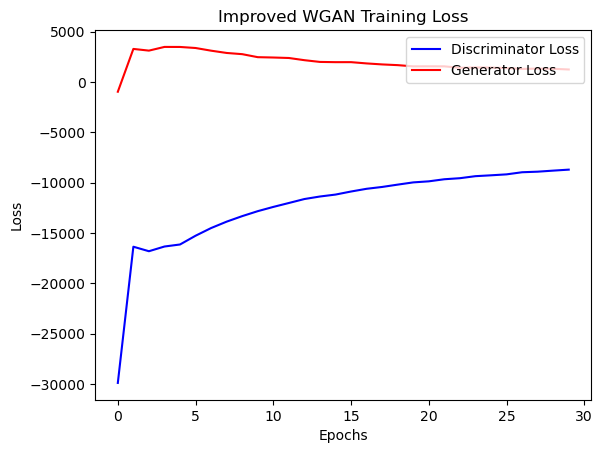

In [27]:
plt.plot(range(EPOCHs), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(EPOCHs), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Improved WGAN Training Loss")
plt.show()

In [ ]:
import moviepy.editor as mpy
utMakeGif(np.array(wsp), "GIF.gif", duration = 2)

In [23]:
# Use new sample to see the performance of the model.
test_noise = tf.random.normal([64, NOISE_DIM])
prediction = generator.predict(test_noise)

In [24]:
def image_grid(images, fig):
    # Create a figure to contain the plot.
    for i in range(64):
        # Start next subplot.
        axs = fig.add_subplot(8, 8, i + 1)
        axs.set_xticks([])
        axs.set_yticks([])
        axs.imshow(np.clip(images[i] * 0.5 + 0.5, 0, 1))



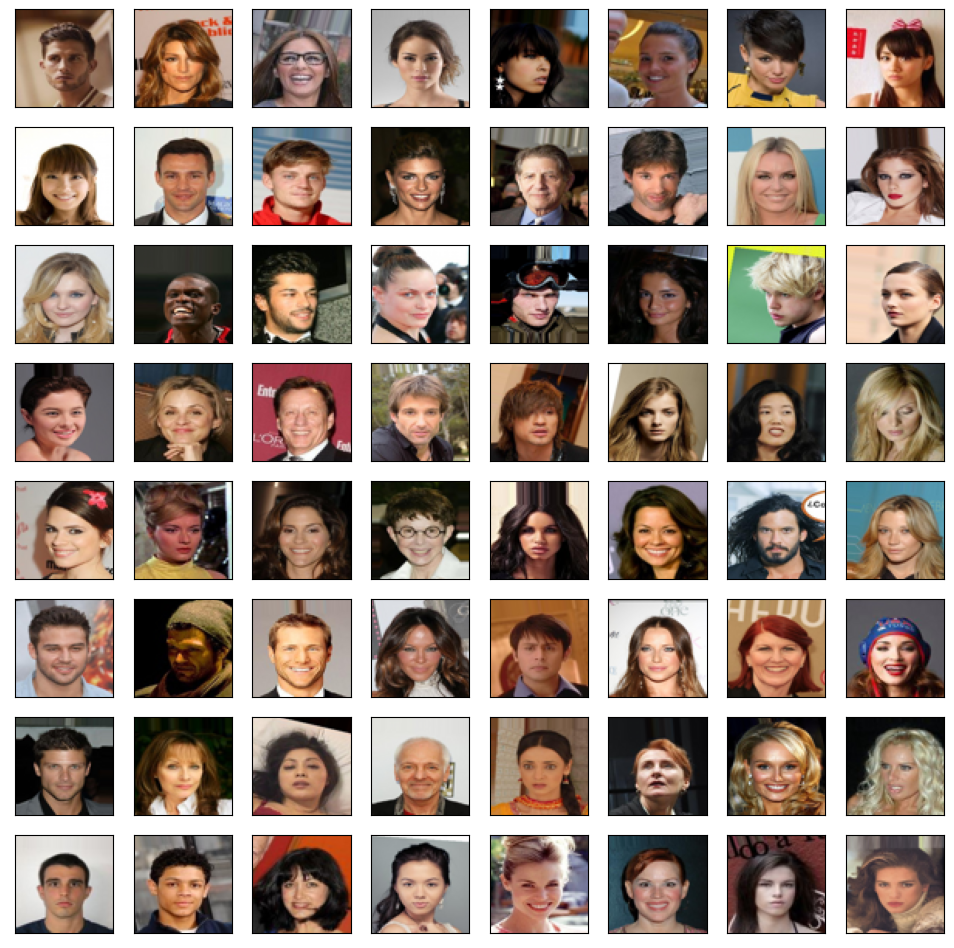

In [25]:
# Plot the real images for dataset
fig1 = plt.figure(figsize=(12,12))
image_grid(sample_img.numpy()[:64], fig1)
plt.show()


In [1]:
# Plot the fake images from the last epoch
fig2 = plt.figure(figsize=(12,12))
image_grid(prediction, fig2)

NameError: name 'plt' is not defined